# ML Session #1 - Lab
In this exercise we will (hopefully) get familiar with some of the concepts we discussed in the slides. We'll do that using k-Nearest Neighbors: a **non-parametric** learning algorithm. We will then use kNN to explore the bias-variance tradeoff and try to come up with the optimal kNN classifier for the given data.
In this notebook, we will use hypothetical and artificial generated data.

Thing's we will do in this notebook:
 - Implement a ML Classifier from scratch
 - Generate an artificial data set to test it on
 - Split our data into train, validation, and test sets
 - Explore basic hyper-parameter tuning of our model
   - When do we Underfit (Bias)
   - When do we overfit (Variance)
 - Use Cross-Validation for more consistent model tuning
 - Optional: Compare our results to sklearn's model 

**Note:** In this notebook, we will use some functions from packages we haven't discussed directly yet (like [numpy](https://numpy.org/), [matplotlib](https://matplotlib.org/) and [scikit-learn](https://scikit-learn.org/stable/index.html)). If you've never used them before, feel free to read up on them in the links above and check out the overview notebooks in this folder.



## Implement k-Nearest Neighbours (kNN)
The kNN algorithm is simple - given a labeled sample set data, and a new sample, predict the label of this sample by using the majority vote over the labels of the k-nearest neighbours (lowest distance) of the new data in the sample set.

For this task, assume each data point is an n-dimensional point in $\mathbb{R}^n$, and each label is either 0 or 1.

Implement a class called KNNClassifier and two methods:
- `fit`: should recieve the training data (an array of shape [n_samples, n_features]) and their labels (array of shape [n_samples]). 
- `predict`: should recieve a set of data (an array of shape [n_samples, n_features]) and **return** their predicted labels (array of shape [n_samples]).

Use simple [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance#Definition) (either implement it yourself or use [scipy.spatial.distance.euclidean](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.euclidean.html) to measure the distance between two points. In case two points in the training have the same distance from a given point to predict, the nearest would be the one appearing first in the training set. 

Use majority vote between all kNN of a point to predict its label. In case the vote of all kNN is tied, you may predict whichever label you wish.

You may look up [sklearn.neighbors.KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for reference if you feel completely lost.

Consider this example case with k=3: You have 5 training data points [(0,0), (0,1), (1,0), (3,3), (3,4)] and their labels [0, 0, 0, 1, 1]. Your predict function recieves a new point (4,3) and needs to calculate the euclidean distance to all the training points. Then, output the label of the majority of the nearest points (in this toy example those would be (3,3), (3,4), and (1,0)): class 1.

**Note:** There are basically 3 ways to implement this. A method using 2 loops, another method using 1 loop, and one using no loops at all.
If you can come up with the vectorized solution (computationally efficient, uses 0 loops) quickly - go ahead. If not, don't worry about it for now! 
**Efficient implementation of kNN is a nice programming exercise, but not the main focus for today.**



In [ ]:
# Run this if you have import problems
!pip install --upgrade numpy scipy scikit-learn



In [ ]:
import numpy as np


class kNNClassifier:
    def __init__(self, k_neighbors):
        # Initialize classifier
        self.n_neighbors = k_neighbors

    def fit(self, X, y):
        # Recieve training X and y
        # Your code here:
        pass

    def predict(self, X):
        # Predict the y for inputted X
        # Your code here:
        return predictions

    def score(self, X, y):
        pred = self.predict(X)
        mean_accuracy = sum(pred == y) / float(len(y))
        return mean_accuracy

    

## Evaluate kNN algorithm on artificial data
As mentioned, kNN is **non-parametric**. This means that no inner parameter in the model is learned using the training set. However, the number of neighbours **k *is* considered a hyper-parameter**, and choosing the optimal value means choosing the balance between bias (underfitting) and variance (overfitting) as discussed earlier today.



### An example: voter party registration

In this example, each voter is described by a vector of two features $(x_0, x_1)$, where $x_0$ describes how wealthy that voter is, and $x_1$ describes how religious the voter is. Label $y=1$ represents a Republican voter, and $y=-1$ represents a Democrat voter.

Use the given function `generate_data(m)` to create m samples with m labels. The labels are created using the following (completely made up) function:

$$
y = \text{sign}\left(x_1 - 0.1\times((x_0-5)^3-x_0^2+(x_0 − 6)^2+80)\right)
$$

Then, a small fraction of the labels (chosen randomly, up to 10%) are flipped to represent some unknown effect of features which are not measured. The sign of 0 is defined as 1 for this case.

Below is an example of generating 500 samples, and plotting them.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def true_boundary_voting_pred(wealth, religiousness):
    return religiousness-0.1*((wealth-5)**3-wealth**2+(wealth-6)**2+80)


def generate_data(m, seed=None):
    # if seed is not None, this function will always generate the same data
    np.random.seed(seed) 

    X = np.random.uniform(low=0.0, high=10.0, size=(m,2))
    y = np.sign(true_boundary_voting_pred(X[:,0], X[:,1]))
    y[y==0] = 1
    samples_to_flip = np.random.randint(0,m//10)
    flip_ind = np.random.choice(m, samples_to_flip, replace=False)
    y[flip_ind] = -y[flip_ind]
    return X, y


def plot_labeled_data(X, y, no_titles=False):
    republicans = (y==1)
    democrats = (y==-1)
    plt.scatter(X[republicans,0], X[republicans,1], c='r')
    plt.scatter(X[democrats,0], X[democrats,1], c='b')
    if not no_titles:
        plt.xlabel('Wealth')
        plt.ylabel('Religiousness')
        plt.title('Red circles represent Republicans, Blues Democrats')
    
    plt.xlim([0, 10]);
    plt.ylim([0, 10]);
    plt.plot(np.linspace(0,10,1000), -true_boundary_voting_pred(np.linspace(0,10,1000), np.zeros(1000)), linewidth=2, c='k');

    

In [ ]:
# Run this several times to see different sampling sets
X, y = generate_data(m=500)
plot_labeled_data(X, y)



### 1. Exploring the properties of kNN
We will generate multiple sample data sets of size 500 (using the function above), and plot the decision plane for increasing values of k (e.g.: 1, 3, 5, 11, 21, 51, 99).

The decision plane will cover the range [0,10] for both axes, coloring the patches that would be classified as Republicans or Democrats in two colors. 

Below is a sample image of how it should look like. Try to guess what the k was in this image!

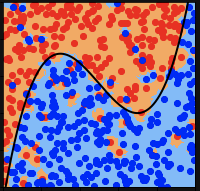
*This image shows a kNN decision plane using colored patches. The black line is the function we used to generate the data.*



In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Colormap


def plot_2D_decision_plane(model, x_min, x_max, y_min, y_max, density=100):
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, density), np.linspace(y_min, y_max, density))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, colors=('xkcd:sky blue','xkcd:pale orange'))



In [ ]:
# Setting up K and num_repetitions
K = [1,3,5,11,21,51,99]
num_repetitions = 5  # change this to 1 or 2 if your implementation takes too much time..

# Accomodating all subplots
plt.figure(figsize=(num_repetitions*4, len(K)*4))

# Looping with kNN of different k's
plt_ind = 1
for k in K:
    # Your code here:
    # Create a kNN object with k
    
    for i in range(num_repetitions):
        # Your code here:
        # Generate data with m=500
        # Fit the data
        # Notice! The predict happens in plot_2D_decision_plane!
        
        plt.subplot(len(K), num_repetitions, plt_ind)
        if plt_ind < num_repetitions:
            plt.title('repetition ' + str(i+1))
        if plt_ind % num_repetitions == 1:
            plt.ylabel('k=' + str(k))
        plot_2D_decision_plane(knn, x_min=0, x_max=10, y_min=0, y_max=10)
        plot_labeled_data(X, y, no_titles=True)
        plt_ind += 1



#### Questions:
Try to answer the following questions:
- How is the decision plain affected from changes in the sample set, as a function of k?
- Can you describe when do we underfit and when we overfit the data?
- How does the complexity of this model depend on k?



#### Answers: 
- ???

- ???

- ???



### 2. Finding the optimal k
 - Sample a single set of size 1000 and divide it randomly to train (0.6) / validation (0.2) / test (0.2) sets. Use [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)! 
 - Plot the train vs validation error for several k values, and choose the best k. Where do you underfit/overfit the data? 
 - Finally, estimate the generalization error of your chosen classifier using the test set.



In [ ]:
from sklearn.model_selection import train_test_split


# We usually want to set the random seed to some number for reproducibility of the results
# This is also true for 'random_state' in train_test_split!
random_seed = 42
X, y = generate_data(m=1000, seed=random_seed)

# Your code here:
# Split the data into training and test sets


# Verifying we got it right
assert X_train.shape == (600, 2)
assert X_validation.shape == (200, 2)
assert X_test.shape == (200, 2)
assert y_train.shape == (600,)
assert y_validation.shape == (200,)
assert y_test.shape == (200,)



In [ ]:
# Building range of k's: 1, 3, 5, 7, .. , 59
K = range(1, 60, 2)

# Initializing error arrays
training_err = np.empty(len(K))
validation_err = np.empty(len(K))

# Running over all k's to get training and validation error
for i in range(len(K)):
    knn = kNNClassifier(K[i])
    knn.fit(X_train, y_train)  
    training_err[i] = 1 - knn.score(X_train, y_train) 
    validation_err[i] = 1 - knn.score(X_validation, y_validation)



In [ ]:
# Using numpy's argmin to find the best k:
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmin.html
opt_k = K[np.argmin(validation_err)]

plt.plot(K, training_err, 'g', label='Train error');
plt.plot(K, validation_err, 'k', label='Generalization error (estimated using validation error)');
plt.axvline(opt_k, color='r', linewidth=2, linestyle=':', label='Optimal k (minimizing the estimated generalization error)');

plt.legend(loc='lower right')
print('Optimal k (minimum validation error) is ' + str(opt_k))



In [ ]:
# Optimal model (based on current knowledge)
knn = kNNClassifier(opt_k)
# Your code here:
# fit all training data (training + previous validation set) to knn

generalization_err = 1 - knn.score(X_test, y_test)
print('Estimated generalization error is: ' + str(generalization_err))



The plot above should look familier from the slides. **Right** to the optimal k (red line) the model **underfit** the data (approaching the optimal k both error rates reduce as the model better describes the data), while **left** to it we see a very clear **overfitting** (train error goes to zero, while generalization error increases dramatically).

It is important to note that the result of the optimal k and the beahviour of the error curves may change for a different dataset (or if we split it differently). One way to handle this is to sample much more data. Unfortunately, in most real world applications this is impossible, and in this case too, we assume the 1000 samples we got are all we have. 

In the next section we will try to reduce this variability using k-fold cross validation! Shall we?



### 3. Using Cross-Validation (CV)
This time, lets put the test data aside (0.2 of the data as before), and apply 5-fold CV on the remaining data to evaluate the performance of each k value. Use [sklearn.model_selection.KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) for this task.

- What is the size of the validation and train set now, in each CV iteration?
- Did your final model selection change? Why?



In [ ]:
from sklearn.model_selection import KFold


def my_cross_val_score(model, X, y, cv):
    # Your code here:
    # Use KFold on your data
    # Iterate over cross validation indices:
        # Fit on train, score on test
    # HINT: Check out sample code at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
    return scores


def optimal_param_using_cross_val(model_class, param_vals, 
                                  cross_val_score_fn, num_folds, 
                                  X_train, y_train, X_test, y_test):
    # find optimal parameter using k-fold cross validation test
    validation_err = np.empty(len(param_vals))
    for i in range(len(param_vals)):
        model = model_class(param_vals[i])
        validation_err[i] = 1 - np.mean(cross_val_score_fn(model, X_train, y_train, cv=num_folds))
  
    opt_p = param_vals[np.argmin(validation_err)]
    print('Optimal parameter (minimum validation error) is ' + str(opt_p) +
          ' with an estimated generalization error of ' + str(np.min(validation_err)))
  
    plt.plot(param_vals, validation_err, 'k', label='Generalization error (estimated using validation error)');
    plt.axvline(opt_p, color='r', linewidth=2, linestyle=':', label='Optimal param (minimizing the estimated generalization error)');
    plt.legend(loc='upper right')
  
    # print the estimated generalization error on the test set
    model = model_class(opt_p)
    model.fit(X_train, y_train)
    generalization_err = 1 - model.score(X_test, y_test)
    print('Estimated generalization error on test set: ' + str(generalization_err))



In [ ]:
# Run it!
optimal_param_using_cross_val(kNNClassifier, K, my_cross_val_score, 5, 
                              tmp_X_train, tmp_y_train, X_test, y_test)



We are using our whole training dataset which contains 800 points, and we are applying a 5-fold cross validation task, so the data is split in each iteration into $\frac{1}{5}$ for test, and $1-\frac{1}{5}=\frac{4}{5}$ for training. That is, in each split 640 samples are used for estimation and 160 samples for *testing* (in this case - validation).

The final model selection (k selection) changed in this case. Is this the best k? Maybe, but due to our relatively small sample size and the potential complexity of this model, we will probably still get enough variablity even in this case to change the final outcome and shift the optimal value of k when different sample sets are generated, or even just different partitions of the data are created in the k-fold cross validation test.

Generally, using k-fold cross validation gives us a more stable estimation of the generalization error rate (as it is averaged over several random partitions of the data into train and test). As we increase the number of folds in the cross validation test we will reduce the variance in the generalization error estimation task. However, it is most likely that at the same time we will increase the bias of this task (meaning- underfit), making us *believe* the generalization error rate is lower than it *actually* is.

Below, I ran 10, 50, 100, and 200-fold cross validation experiments. The results suggest that **the optimal k for in this case is probably around 9**.



In [ ]:
optimal_param_using_cross_val(kNNClassifier, K, my_cross_val_score, 10, 
                              tmp_X_train, tmp_y_train, X_test, y_test)



In [ ]:
optimal_param_using_cross_val(kNNClassifier, K, my_cross_val_score, 50, 
                              tmp_X_train, tmp_y_train, X_test, y_test)



In [ ]:
optimal_param_using_cross_val(kNNClassifier, K, my_cross_val_score, 100, 
                              tmp_X_train, tmp_y_train, X_test, y_test)



In [ ]:
optimal_param_using_cross_val(kNNClassifier, K, my_cross_val_score, 200, 
                              tmp_X_train, tmp_y_train, X_test, y_test)



### 4. Comparison with `KNeighborsClassifier` and `cross_val_score` from `sklearn`
An interesting task you can take on yourself when you implement known algorithms, is to compare your results to an 'official' implementation. 

Let's compare our results to Scikit-learn's kNN classifier and Cross-Validation scorer. We *should* get highly similar results!



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score



In [ ]:
# Using sklearn's kNN Classifier with our CV scorer, 5-fold CV
optimal_param_using_cross_val(KNeighborsClassifier, K, my_cross_val_score, 5, 
                              tmp_X_train, tmp_y_train, X_test, y_test)



In [ ]:
# Using sklearn's kNN Classifier with their CV scorer, 5-fold CV
optimal_param_using_cross_val(KNeighborsClassifier, K, cross_val_score, 5, 
                              tmp_X_train, tmp_y_train, X_test, y_test)



In [ ]:
# Using sklearn's kNN Classifier with their CV scorer, 10-fold CV
optimal_param_using_cross_val(KNeighborsClassifier, K, cross_val_score, 10, 
                              tmp_X_train, tmp_y_train, X_test, y_test)



In [ ]:
# Using sklearn's kNN Classifier with their CV scorer, 50-fold CV
optimal_param_using_cross_val(KNeighborsClassifier, K, cross_val_score, 50, 
                              tmp_X_train, tmp_y_train, X_test, y_test)



## References - Recommended Reading!
- http://scott.fortmann-roe.com/docs/BiasVariance.html
- http://scott.fortmann-roe.com/docs/MeasuringError.html

